# Metadata 

```yaml
Course:   DS 5001 
Module:   08a Topic Models 2 HW
Topic:    LDA with SciKit Learn KEY
Author:   R.C. Alvarado
Date:     20 March 2023 (revised)
```

# Instructions

In this week’s homework, you will create topic models using Scikit Learn’s `LatentDirichletAllocation`  class. Using the notebooks from the previous week (Module 08), and the `CORPUS` and `LIB` tables for the `novels` collection (found in the `novels` subdirectory of the shared Dropbox folder), do the following:

1. Generate two topic models, one for paragraphs as documents (i.e. bags), the other with chapters as documents. A topic model in this context comprises three tables: `THETA`, `PHI`, and `TOPICS`. For each model, use the following parameters:

  * `CountVectorizer`
    - max_features = $4000$
    - stop_words = 'english'
  * `LatentDirichletAllocation`
    - n_components = $20$
    - max_iter = $5$
    - learning_offset = $50.$
    - random_state = $0$ 
  * Hyperparameters
    - Use only nouns (`NN` and `NNS`)
    - Number of words used to characterize a topic: $7$

**Note**: You may want to generalize the notebook code use to generate topic models by creating a class, or at least a library of functions, to perform various tasks. This will allow to quickly run topic models with bag as a parameter. An added benefit of creating a class for exploring topic models is that you can use it in your final projects.

Once you are done with these tasks, answer the following questions:

1. Use the `PHI` table from each model to compute the entropy $H$ of the distribution over topics. Which bag generates a lower entropy distribution? Hint: To get $H$ work with the L1 normalized vector of word weight sums by topic in the `PHI` table. 

2. Sort the topics in each model's `PHI` table by topic entropy in descending order. Are the first topics in the two models about the same? In other words, do they yield similar interpretations?

3. What topic from each model is most strongly associated with each genre? Note that your answer have four parts.

4. Using the `THETA` table from the Chapters model, get the mean topic weights for each book. Which book is most strongly associated with the gothic genre `g`, based on the weight of that genre's most representative topic (as discovered in the previous question)?

5. How would you characterize the subject matter of the two genres based on their topic models? Consider the words associated with the dominant topics from each model, but also the models overall.

# Set Up

In [10]:
data_in = "../../data/novels"
data_prefix = 'novels'

In [11]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
BOOK = OHCO[:1]
CHAP = OHCO[:2]
PARA = OHCO[:3]
BAG = PARA

In [12]:
import pandas as pd
import numpy as np

# Import Data

In [13]:
TOKENS = pd.read_csv(f"{data_in}/{data_prefix}-CORPUS.csv").set_index(OHCO)
LIB = pd.read_csv(f"{data_in}/{data_prefix}-LIB.csv").set_index('book_id')
LABELS = ['author_id','genre_id'] # These are from the LIB table

In [14]:
TOKENS

pos     term_str
book_id         chap_id para_num sent_num token_num                  
secretadversary 1       0        1        0           DT          the
                                          1          NNP        young
                                          2          NNP  adventurers
                                          3          NNP          ltd
                        1        0        0           JJ        tommy
...                                                  ...          ...
baskervilles    11      114      1        7          RBR         more
                                          8           JJ  comfortable
                                          9           IN      outside
                                          10          IN         than
                                          11          NN           in

[1500417 rows x 2 columns]

# Define Class

In [15]:
import pandas as pd # Put here again in case we copy into a separate file
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

class TopicExplorer:
    
    n_features = 4000
    stopwords = 'english'
    lda_num_topics = 20
    lda_max_iter = 5
    lda_n_top_terms = 7
    
    def __init__(self, tokens_df, lib_df, bag, labels=[]):
        self.TOKENS = tokens_df
        self.LIB = lib_df
        self.bag = bag
        self.labels = labels
        
    def generate_tables(self):
        print("BAG:", self.bag[-1])
        print("LABELS:", self.labels)
        print("Getting DOCS")
        self._get_docs()
        print("Getting TERMS")
        self._get_count_model()
        print("Getting THETA, PHI")
        self._get_topic_model()
        print("Getting TOPICS")
        self._get_topics()
        print('Binding LIB labels to THETA')
        self._bind_labels()
        print("Done.")
        return self
        
    def _get_docs(self, pos_remove_pat=r'^NNS?$'):
        self.DOCS = self.TOKENS[self.TOKENS.pos.str.match(pos_remove_pat)]\
            .groupby(self.bag).term_str\
            .apply(lambda x: ' '.join(x))\
            .to_frame()\
            .rename(columns={'term_str':'doc_str'})
        
    def _get_count_model(self):
        self.count_engine = CountVectorizer(max_features=self.n_features, 
                                            stop_words=self.stopwords)
        self.count_model = self.count_engine.fit_transform(self.DOCS.doc_str)
        self.TERMS = self.count_engine.get_feature_names_out()
        
    def _get_topic_model(self):
        self.lda_engine = LDA(n_components=self.lda_num_topics, 
                              max_iter=self.lda_max_iter, 
                              learning_offset=50., 
                              random_state=0)
        self.THETA = pd.DataFrame(self.lda_engine.fit_transform(self.count_model), 
                                  index=self.DOCS.index)
        self.THETA.columns.name = 'topic_id'
        self.PHI = pd.DataFrame(self.lda_engine.components_, columns=self.TERMS)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
    def _get_topics(self, n_terms=10):
        self.TOPICS = self.PHI.stack().to_frame('weight')\
            .groupby('topic_id')\
            .apply(lambda x: x.weight.sort_values(ascending=False)\
               .head(self.lda_n_top_terms)\
               .reset_index()\
               .drop('topic_id', axis=1)\
               .term_str)
        self.TOPICS['label'] = self.TOPICS[[t for t in range(self.lda_n_top_terms)]]\
            .apply(lambda x: str(x.name)\
                   .zfill(len(str(self.lda_num_topics))) + ' ' + ' '.join(x), axis=1)
        self.TOPICS['doc_weight_sum'] = self.THETA.sum()
        self.topic_cols = [t for t in range(self.lda_num_topics)]
        
    def _bind_labels(self):
        self.LABELS = {}
        self.LABEL_VALUES = {}
        for label in self.labels:
            self.THETA[label] = self.THETA\
                .apply(lambda x: self.LIB.loc[x.name[0], label], axis=1)
            self.LABELS[label] = self.THETA.groupby(label)[self.topic_cols].mean().T  
            self.THETA = self.THETA.drop(label, axis=1) # Don't keep the column
            self.LABELS[label].index.name = 'topic_id'
            self.LABELS[label]['label'] = self.TOPICS['label']
            self.LABEL_VALUES[label] = sorted(list(set(self.LIB[label])))
            
    def show_dominant_label_topic(self, label):
        X = self.LABELS[label][self.LABEL_VALUES[label]].idxmax()
        return X.to_frame('topic_id').topic_id.map(self.TOPICS.label)
            
    def show_label_values(self):
        for label in self.LABEL_VALUES:
            print(label, ": ", self.LABEL_VALUES[label])
        
    def show_topic_bar(self):
        fig_height = self.lda_num_topics / 3
        self.TOPICS.sort_values('doc_weight_sum', ascending=True)\
            .plot.barh(y='doc_weight_sum', x='label', figsize=(5, fig_height));
        
    def show_topic_label_heatmap(self, label):
        return MP.LABELS[label][MP.LABEL_VALUES[label]].style.background_gradient()
        
    def show_label_comparison_plot(self, label, label_value_x, label_value_y):
        px.scatter(self.LABELS[label].reset_index(), label_value_x, label_value_y, 
                   hover_name='label', text='topic_id', width=800, height=600)\
            .update_traces(mode='text').show()        

# Generate tables for each bag

In [16]:
MP = TopicExplorer(TOKENS, LIB, PARA, LABELS).generate_tables()

BAG: para_num
LABELS: ['author_id', 'genre_id']
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.


In [17]:
MC = TopicExplorer(TOKENS, LIB, CHAP, LABELS).generate_tables()

BAG: chap_id
LABELS: ['author_id', 'genre_id']
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.


# Q1

Use the `PHI` table from each model to compute the entropy $H$ of the distribution over topics. Which bag generates a lower entropy distribution? 

Hint: To get $H$ work with the L1 normalized vector of word weight sums by topic in the `PHI` table. 

**Answer:** Chapters.


In [27]:
MP.TOPICS['phi_p'] = MP.PHI.T.sum() / MP.PHI.T.sum().sum()
MC.TOPICS['phi_p'] = MC.PHI.T.sum() / MC.PHI.T.sum().sum()

In [28]:
MP.TOPICS['phi_h'] = MP.TOPICS.phi_p * np.log2(1/MP.TOPICS.phi_p)
MC.TOPICS['phi_h'] = MC.TOPICS.phi_p * np.log2(1/MC.TOPICS.phi_p)

In [29]:
MP.TOPICS.phi_h.sum(), MC.TOPICS.phi_h.sum()

(4.252625756822118, 3.6914378055200703)

# Q2

Sort the topics in each model's `PHI` table by topic entropy in descending order. Are the first topics in the two models 
about the same? In other words, do they yield similar interpretations?

**Answer:** No.

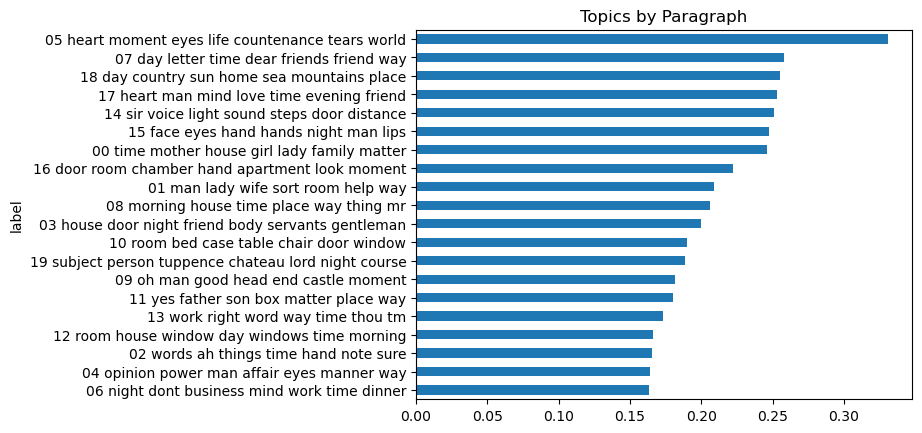

In [30]:
MP.TOPICS.reset_index().set_index('label').phi_h.sort_values().plot.barh(title="Topics by Paragraph");

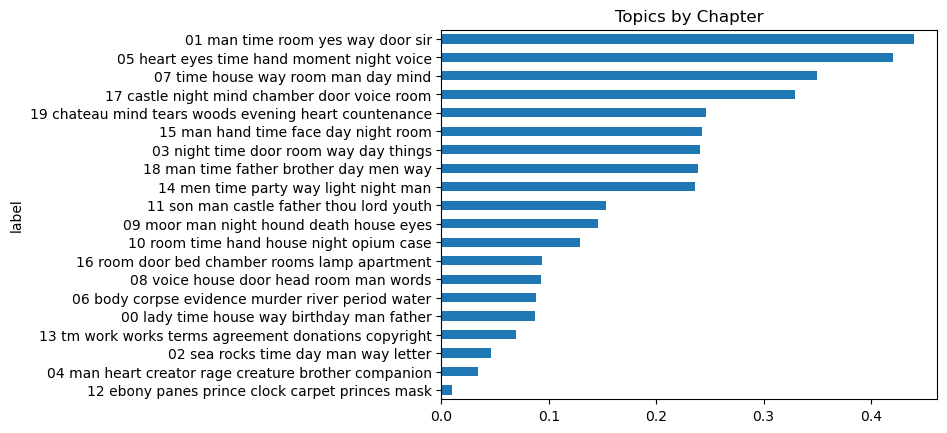

In [31]:
MC.TOPICS.reset_index().set_index('label').phi_h.sort_values().plot.barh(title="Topics by Chapter");

# Q3

What topic from each model is most strongly associated with each genre? 

| | d | g |
|--|--|--|
| Chapter | 01 man time room yes way door sir face hand house | 05 heart eyes time hand moment night voice lif...|
| Paragraph | 08 morning house time place way thing mr thats... | 05 heart moment eyes life countenance tears wo... |


In [40]:
MC.show_dominant_label_topic('genre_id')

genre_id
d             01 man time room yes way door sir
g    05 heart eyes time hand moment night voice
Name: topic_id, dtype: object

In [41]:
MP.show_dominant_label_topic('genre_id')

genre_id
d             08 morning house time place way thing mr
g    05 heart moment eyes life countenance tears world
Name: topic_id, dtype: object

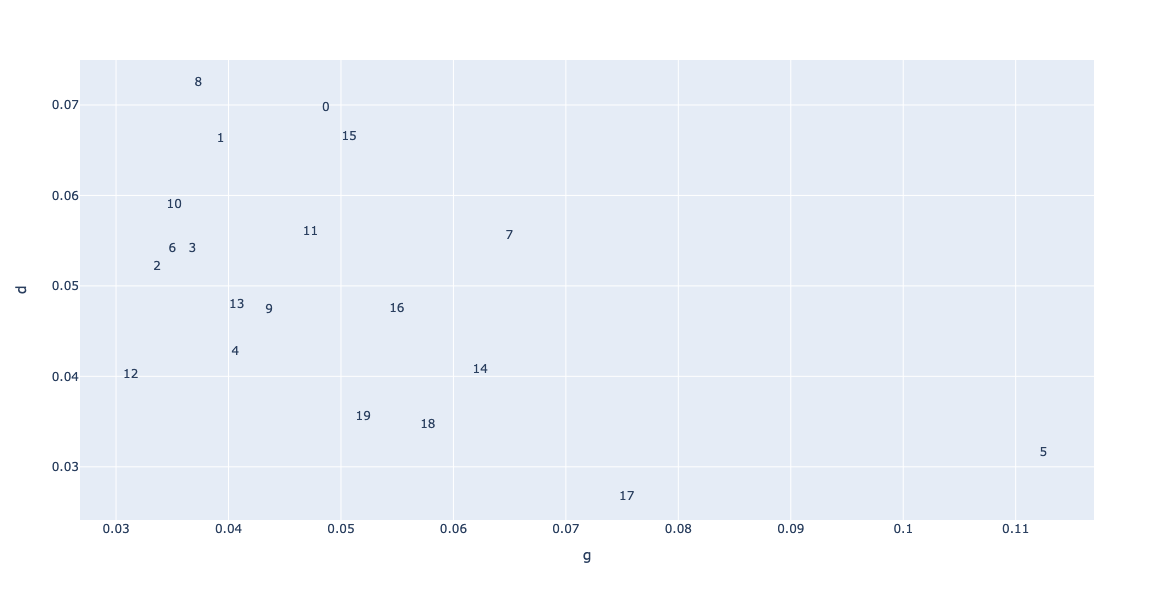

In [42]:
MP.show_label_comparison_plot('genre_id', 'g', 'd')

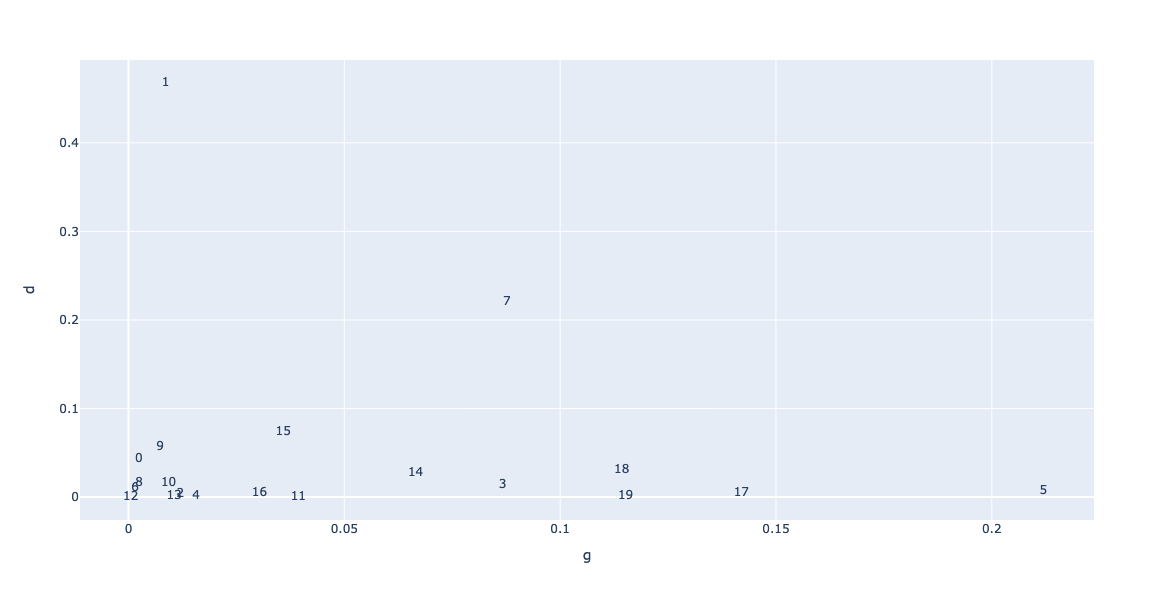

In [43]:
MC.show_label_comparison_plot('genre_id','g','d')

# Q4

Using the `THETA` table from the Chapters model, get the mean topic weights for each book. Which book is most strongly associated with the gothic genre `g`, based on the weight of that genre's most representative topic (as discovered in the previous question)?

**Answer:** Monk

In [44]:
MC.THETA.groupby('book_id').mean()[5].idxmax()

'monk'

In [45]:
MC.THETA.groupby('book_id').mean().style.background_gradient(axis=None)

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
book_id,,,,,,,,,,,,,,,,,,,,
adventures,0.000828,0.418945,0.000039,0.002241,0.000039,0.003784,0.000039,0.038878,0.022939,0.054198,0.003572,0.002858,0.000039,0.000313,0.004494,0.398504,0.004142,0.002636,0.041471,0.000039
baskervilles,0.000812,0.414274,0.000089,0.002167,0.000089,0.009695,0.006642,0.059387,0.000089,0.356495,0.000089,0.000089,0.000089,0.002534,0.030142,0.036968,0.003114,0.015068,0.062077,0.000089
castleofotranto,0.000041,0.000041,0.000041,0.000041,0.000041,0.023148,0.000041,0.000041,0.000587,0.000041,0.000041,0.811165,0.000041,0.164443,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041
christmascarole,0.000071,0.229655,0.000071,0.062990,0.000071,0.000071,0.000071,0.020979,0.002276,0.001926,0.000071,0.001651,0.000071,0.000071,0.099854,0.097997,0.003528,0.000071,0.478438,0.000071
dracula,0.000062,0.010079,0.040029,0.541501,0.000062,0.015929,0.000062,0.034058,0.000062,0.001156,0.028031,0.000062,0.000062,0.000062,0.015820,0.170249,0.017614,0.018019,0.107016,0.000062
frankenstein,0.003804,0.000158,0.000158,0.006660,0.062474,0.284310,0.006261,0.025802,0.000158,0.002357,0.016381,0.005853,0.000158,0.001606,0.152014,0.036595,0.000158,0.195686,0.180214,0.019194
marieroget,0.000015,0.000015,0.000015,0.000015,0.000015,0.013225,0.835984,0.000015,0.021382,0.000015,0.129165,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
monk,0.000034,0.001713,0.000034,0.001860,0.000034,0.977318,0.000034,0.007560,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.001467,0.000034,0.000034,0.002916,0.006724,0.000034
moonstone,0.133761,0.127440,0.010962,0.019476,0.000114,0.007403,0.004192,0.621086,0.006513,0.001049,0.031700,0.000114,0.000114,0.000367,0.019020,0.002193,0.009365,0.000338,0.004678,0.000114


# Q5

How would you characterize the subject matter of the two genres based on their topic models? 

Consider the words associated with the dominant topics from each model, but also the models overall.

**Answer**: Based on this, one way to characterize the two genres is that gothic novels are internal and emotional and detective novels are external and focus on material things, like money and evidence.